In [1]:
#importing necessary tools and libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',50)
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#importing dataset
df= pd.read_excel('ANZ synthesised transaction dataset.xlsx')

In [3]:
df.head(2)

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit


In [4]:
df['txn_description'].value_counts()

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

In [5]:
#dataframe containing information relating to salary
df_salary = pd.DataFrame(df[df['txn_description']=='PAY/SALARY']).reset_index()

#dataframe containing information relating to all other transactions(sales, pos, payment, interbank, phonebank)
df_other_txn = pd.DataFrame(df[df['txn_description']!='PAY/SALARY']).reset_index()


In [6]:
#group data for further analysis
df1= df_salary.groupby('customer_id').mean()
df2= df_salary.groupby('customer_id').count()
df3= df_salary.groupby('customer_id').sum()
# df_max= df.groupby('customer_id').max()
# df_min= df.groupby('customer_id').min()
df_4= df_other_txn.groupby('customer_id').mean()

In [7]:
#drop irrelevant features
df1.drop(['index','merchant_code','card_present_flag'], axis=1, inplace=True) 

In [8]:
# df1['annual_salary']= df1['amount']*(df2['amount']/3)*12

df1['annual_salary']= (df1['amount'])*12    #calculate annual salary
df1['other_trans']= (df_4['amount'])*12
df1['count_trans']= df2['txn_description']*4

In [9]:
df1.drop(['amount','balance'], axis=1, inplace=True)

In [10]:
df1.head(2)

,age,annual_salary,other_trans,count_trans
customer_id,,,,
CUS-1005756958,53.0,11645.64,730.572000,52
CUS-1117979751,21.0,42943.80,1152.750968,28


In [11]:
import statsmodels.api as sm
import scipy.stats as stats

In [12]:
df1.describe()

,age,annual_salary,other_trans,count_trans
count,100.000000,100.000000,100.000000,100.000000
mean,31.770000,27567.286800,736.162527,35.320000
std,11.544254,16773.407644,344.607064,14.606543
min,18.000000,6912.000000,255.749149,8.000000
25%,22.000000,13839.720000,503.834073,24.000000
50%,29.500000,23393.160000,647.441870,28.000000
75%,39.250000,34640.700000,823.846800,52.000000
max,78.000000,106031.760000,2207.871045,56.000000


In [13]:
# sns.boxplot(df1['annual_salary'])

In [14]:
# sns.boxplot(df1['age'])

In [15]:
# sns.boxplot(df1['other_trans'])

In [16]:
#transform independent variables using appropriate transformation
df1['other_trans']= np.sqrt(df1['other_trans'])
df1['count_trans']= np.sqrt(df1['count_trans'])
df1['age']= 1/ np.sqrt(df1['age'])
# df1['balance']= 1/ np.sqrt(df1['balance'])

In [17]:
df1.corr()

,age,annual_salary,other_trans,count_trans
age,1.000000,0.083551,-0.309846,-0.153050
annual_salary,0.083551,1.000000,-0.063802,-0.721290
other_trans,-0.309846,-0.063802,1.000000,0.128352
count_trans,-0.153050,-0.721290,0.128352,1.000000


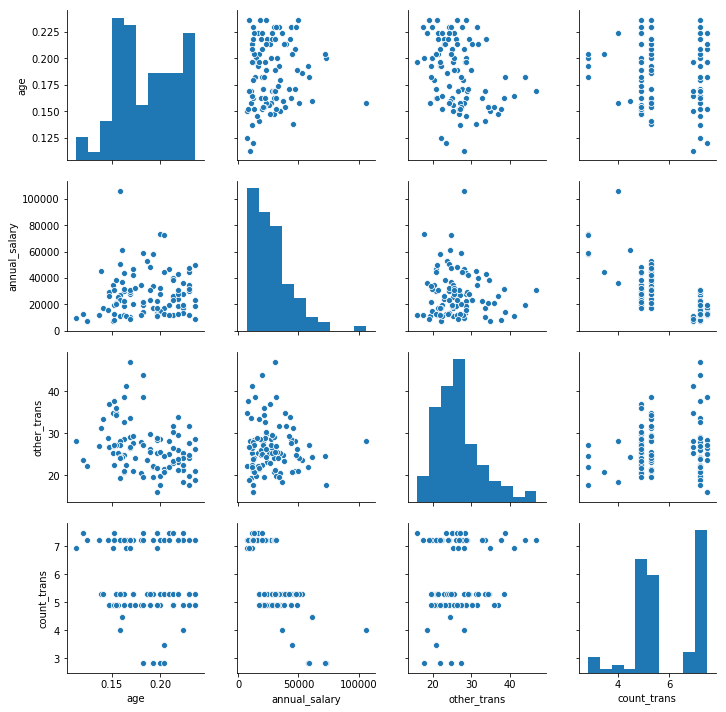

In [18]:
sns.pairplot(df1)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression
import xgboost
from xgboost.sklearn import XGBRegressor

In [20]:
# specify the target variable
target= df1['annual_salary']

In [21]:
df1.drop(['annual_salary'], axis=1, inplace=True)

In [22]:
df1.head(2)

,age,other_trans,count_trans
customer_id,,,
CUS-1005756958,0.137361,27.029095,7.211103
CUS-1117979751,0.218218,33.952186,5.291503


In [23]:
from sklearn.preprocessing import StandardScaler
train_s = StandardScaler().fit_transform(df1)
s_train = pd.DataFrame(train_s, columns = df1.columns)

In [24]:
#train and test split for model validation
x_train, x_test, y_train, y_test=  train_test_split(s_train,target, test_size= 0.3, random_state= 0)

## A. Linear Regression

In [25]:
#regression summary
X2 = sm.add_constant(df1)
est = sm.OLS(target, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:          annual_salary   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     34.87
Date:                Sun, 06 Sep 2020   Prob (F-statistic):           2.48e-15
Time:                        19:02:50   Log-Likelihood:                -1077.3
No. Observations:                 100   AIC:                             2163.
Df Residuals:                      96   BIC:                             2173.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.348e+04   1.24e+04      6.749      

In [26]:
#fit the regression model and generate predictions
lr= LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

In [27]:
#calculate residuals to further examine the assumptions of regression model
resid= y_test - y_pred

## Checking the assumptions of regression model

### 1. For checking linearity in regression model
To detect nonlinearity we inspect plots of observed vs. predicted values or residuals vs. predicted values. 
The desired outcome is that points are symmetrically distributed around a diagonal line in the former plot or around a horizontal line in the latter one. In both cases with a roughly constant variance.
Observing a ‘bowed’ pattern indicates that the model makes systematic errors whenever it is making unusually large or
small predictions.

[Text(0, 0.5, 'Residuals'), Text(0.5, 0, 'Predicted')]

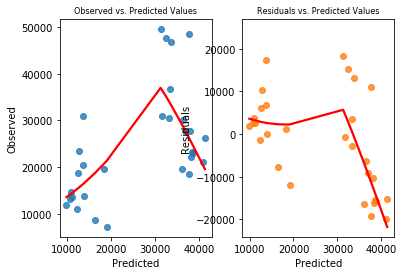

In [28]:
fig, ax = plt.subplots(1,2)
    
sns.regplot(x=y_pred, y=y_test, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=8)
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=y_pred, y=resid, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=8)
ax[1].set(xlabel='Predicted', ylabel='Residuals')

#### Linearity assumption is not satisfied, therefore, the regression model might not produce the best results.

### 2. Checking for Mutlicollinearity
We look at the VIF. We can detect multicollinearity using the variance inflation factor (VIF). The interpretation of VIF is as follows: the square root of a given variable’s VIF shows how much larger the standard error is, compared with what it would be if that predictor were uncorrelated with the other features in the model. If no features are correlated, then all values for VIF will be 1. A rule of thumb for removal could be VIF larger than 10

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculating VIF
vif = pd.DataFrame()
vif["variables"] = x_train.columns
vif["VIF"] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]

print(vif)

     variables       VIF
0          age  1.105855
1  other_trans  1.104682
2  count_trans  1.041447


### 3. Checking for homoscedasticity of residuals
 We can use statistical test to check for homescedastic residuals: Breusch-Pagan test. The null hypothesis assumes homoscedasticity and a p-value below a certain level indicates we should reject the null in favor of heteroscedasticity.

In [30]:
import statsmodels.stats.api as sms
bp_test = pd.DataFrame(sms.het_breuschpagan(resid, x_test[['age','other_trans', 'count_trans']]), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])
print(bp_test)

                                  value
Lagrange multiplier statistic  6.028501
p-value                        0.049083
f-value                        2.263376
f p-value                      0.103838


### 4. Checking for autocorrelation of residuals
To investigate if autocorrelation is present, we use ACF (autocorrelation function) plots and Durbin-Watson test. In the former case, we want to see if the value of ACF is significant for any lag (in case of no time-series data, the row number is used). While calling the function, we indicate the significance level we are interested in and the critical area is plotted on the graph. Significant correlations lie outside of that area.

The second approach is using the Durbin-Watson test. And this statistics is already available in regression summary
the test statistic always has a value between 0 and 4
value of 2 means that there is no autocorrelation in the sample
values < 2 indicate positive autocorrelation, values > 2 negative one.

C:\Users\JYOTI\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


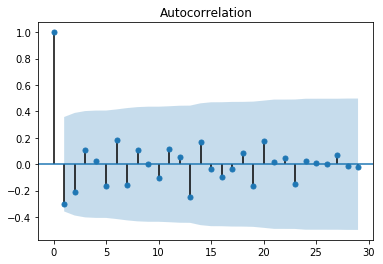

In [31]:
#plotting acf(autocorrealtion function)
import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(resid, lags=29 , alpha=0.05)
acf.show()

### 5. Checking if the features and residuals are uncorrelated

In [32]:
from scipy.stats.stats import pearsonr

for column in x_test.columns:
    corr_test = pearsonr(x_test[column], resid)
    print(f'{column} --correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')


age --correlation: 0.1190, p-value: 0.5310
other_trans --correlation: -0.3188, p-value: 0.0859
count_trans --correlation: 0.4281, p-value: 0.0183


### 6. Checking for the normality of residuals
To investigate this assumption we can look at:
1) QQ plots of the residuals. A bow-shaped pattern of deviations from the diagonal implies that the residuals have excessive skewness (i.e., the distribution is not symmetrical, with too many large residuals in one direction). The s-shaped pattern of deviations implies excessive kurtosis of the residuals — there are either too many or two few large errors in both directions. 2) use statistical tests such as the Kolmogorov-Smirnov test, the Shapiro-Wilk test, the Jarque-Bera test, and the Anderson-Darling test


Jarque-Bera test statistic: 1.4463, p-value: 0.4852261869833422
Shapiro-Wilk test statistic: 0.9539, p-value: 0.2147


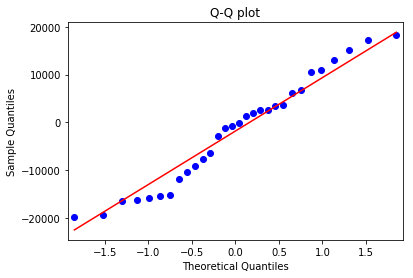

In [33]:
sm.ProbPlot(resid).qqplot(line='s');
plt.title('Q-Q plot');

jb = stats.jarque_bera(resid)
sw = stats.shapiro(resid)
ad = stats.anderson(resid, dist='norm')
ks = stats.kstest(resid, 'norm')
    
print(f'Jarque-Bera test statistic: {jb[0]:.4f}, p-value: {jb[1]}')
print(f'Shapiro-Wilk test statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')


#### All other assumptions of the regression model except the linearity in model are satisfied. 

In [34]:
df_c = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_c.tail()

,Actual,Predicted
customer_id,,
CUS-1790886359,36853.68,33394.051735
CUS-443776336,11886.60,9956.162707
CUS-1140341822,22998.12,38706.033490
CUS-2695611575,11009.40,12273.595214
CUS-3395687666,21093.72,40967.457282


In [1]:
# plot Actual vs Predicted
c = [i for i in range(len(x_test))]
fig = plt.figure()# plot Actual vs Predicted
plt.plot(c,y_test, color="blue", linewidth=3.5, linestyle="-")     #Plotting Actual
plt.plot(c,y_pred, color="red",  linewidth=3.5, linestyle="-")  #Plotting predicted
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('salary', fontsize=16)

NameError: name 'x_test' is not defined

In [36]:
#Model evaluation 
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('r2_score:', r2_score(y_test, y_pred))

Mean Squared Error: 128230787.36189128
Root Mean Squared Error: 11323.9033624405
r2_score: 0.056708082159477535


## B. Decision Tree Regressor

In [37]:
from sklearn.tree import DecisionTreeRegressor
dt= DecisionTreeRegressor(random_state=0)
dt.fit(x_train, y_train)
y_pred= dt.predict(x_test)

Text(0, 0.5, 'salary')

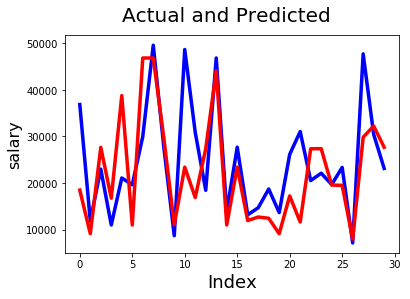

In [38]:
# plot Actual vs Predicted
c = [i for i in range(len(x_test))]
fig = plt.figure()
plt.plot(c,y_test, color="blue", linewidth=3.5, linestyle="-")     #Plotting Actual
plt.plot(c,y_pred, color="red",  linewidth=3.5, linestyle="-")  #Plotting predicted
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('salary', fontsize=16)
# Text(0, 0.5, 'salary')

In [39]:
#Model evaluation 
# print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Root Mean Squared Error: 9982.054861359962


### Linearity assumption for regression model was violated and because decision tree models map non-linear relationship well, we can see an improvement in results obtained by using Decision Tree model. 
### The RMSE for Decision tree model decreased to 9982.05 whereas it is 11323.90 for Multiple Regression model.


